In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [7]:
region = "Kuro_new_2"

In [8]:
data_CESM = np.load(f"/home/hmelzer/work/esn/CESM/Data/ssh_{region}_5d.npy")
lon = np.load(f"/home/hmelzer/work/esn/CESM/Data/lon_{region}.npy")
lat = np.load(f"/home/hmelzer/work/esn/CESM/Data/lat_{region}.npy")

**IMED**

In [9]:
from imed import transform as ST

In [10]:
sig  =  (0,1,1)
ep   =  1e-2

In [11]:
data_ST = ST(data_CESM, sigma = sig, inv = False, eps = ep, method = 'DCT')

In [12]:
data_snapshot = data_CESM[0,:,:]
data_ST_snapshot = data_ST[0,:,:]

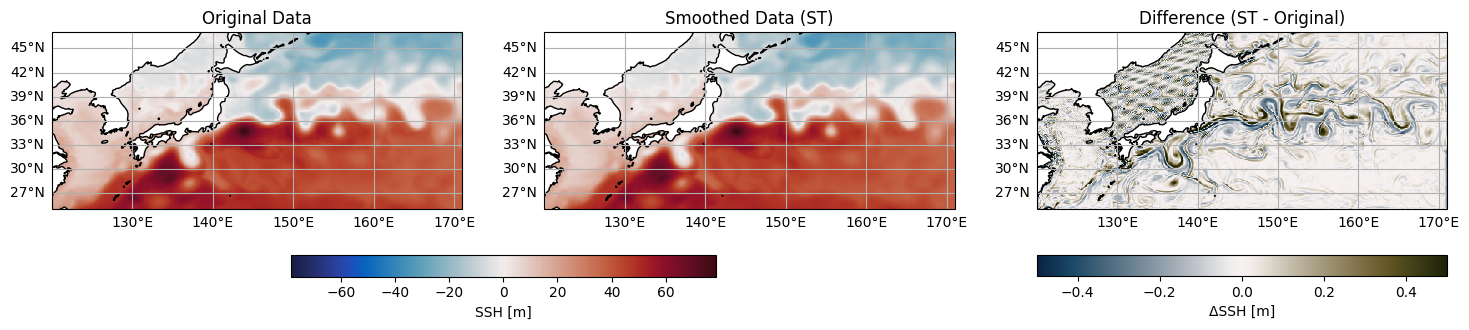

In [13]:
# Compute the difference
diff = data_ST_snapshot - data_snapshot

# Determine symmetric vmin/vmax for data and data_ST
vlim = np.nanmax(np.abs([data_snapshot, data_ST_snapshot]))

# Set symmetric vlim for difference manually
vlim_diff = 0.5

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for each subplot
titles = ['Original Data', 'Smoothed Data (ST)', 'Difference (ST - Original)']
cmaps = [cmocean.cm.balance, cmocean.cm.balance, cmocean.cm.diff]
vlims = [(-vlim, vlim), (-vlim, vlim), (-vlim_diff, vlim_diff)]
datasets = [data_snapshot, data_ST_snapshot, diff]

# Store the QuadMesh objects
pcms = []

for i, (ax, title, cmap, (vmin, vmax), dat) in enumerate(zip(axes, titles, cmaps, vlims, datasets)):
    pcm = ax.pcolormesh(lon, lat, dat, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax,
                        transform=ccrs.PlateCarree())
    pcms.append(pcm)
    
    ax.add_feature(cfeature.LAND, facecolor='white', zorder=1)
    ax.coastlines()
    ax.set_title(title)
    ax.set_extent([lon.min() + 1, lon.max() - 1, lat.min() + 1, lat.max() - 1], crs=ccrs.PlateCarree())

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    gl.top_labels = False
    gl.right_labels = False

# Shared colorbar under the first two plots
cbar1 = fig.colorbar(pcms[0], ax=axes[:2], orientation='horizontal', fraction=0.046, pad=0.1)
cbar1.set_label('SSH [m]')

# Separate colorbar under the third plot
cbar2 = fig.colorbar(pcms[2], ax=axes[2], orientation='horizontal', fraction=0.046, pad=0.1)
cbar2.set_label('ΔSSH [m]')

# plt.tight_layout()
plt.show()


**Input Mappings**

In [24]:
from esn_dev.input_map import make_operation

In [25]:
def get_operation_outputs(img, specs):
    """
    Apply each input map operation to an image and return the raw (unscaled) outputs.

    Args:
        img (np.ndarray): 2D input image.
        specs (list of dict): List of operation specs.

    Returns:
        dict[str, np.ndarray]: Dictionary mapping operation names to output arrays.
    """
    results = {}
    for i, spec in enumerate(specs):
        op = make_operation(spec)
        raw_op = op.op  # remove ScaleOp wrapper
        out = raw_op(img)

        # Try to reshape if 2D
        try:
            shape = raw_op.output_shape(img.shape)
            out = out.reshape(shape)
        except:
            pass  # leave flat if can't reshape

        op_name = f"{i:02d}_{spec['type']}"
        results[op_name] = out

    return results

In [51]:
img = data_snapshot

# Your specs
k = 0.1
input_size = img.size
specs = [
    {"type": "pixels", "size": (10, 10), "factor": k},
    {"type": "conv", "size": (10, 10), "kernel": "gauss",  "factor": k},
    {"type": "conv", "size": (10, 10), "kernel": "random",  "factor": k},
    {"type": "gradient", "factor": 0.001},
    {"type": "vorticity", "factor": 0.001},
    {"type": "dct", "size": (10, 10), "factor": k},
    {"type": "random_weights", "input_size": input_size, "hidden_size": 10000, "factor": 10}
]

# Get outputs
outputs = get_operation_outputs(img, specs)


In [52]:
pixels         = outputs["00_pixels"]
conv_gauss     = outputs["01_conv"]
conv_random    = outputs["02_conv"]
gradient       = outputs["03_gradient"]
vorticity      = outputs["04_vorticity"]
dct            = outputs["05_dct"]
rand_weights   = outputs["06_random_weights"]


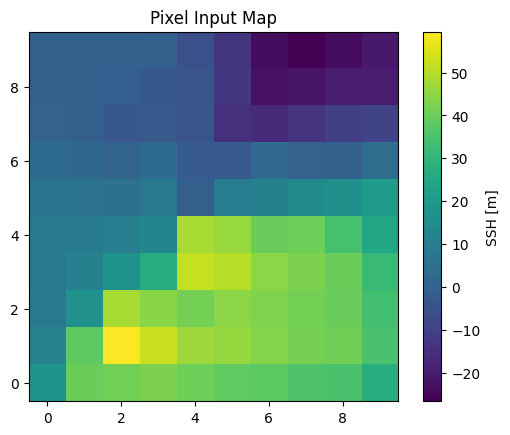

In [71]:
plt.Figure
plt.imshow(pixels, origin='lower')
plt.colorbar(label = "SSH [m]")
plt.title("Pixel Input Map")
plt.show()

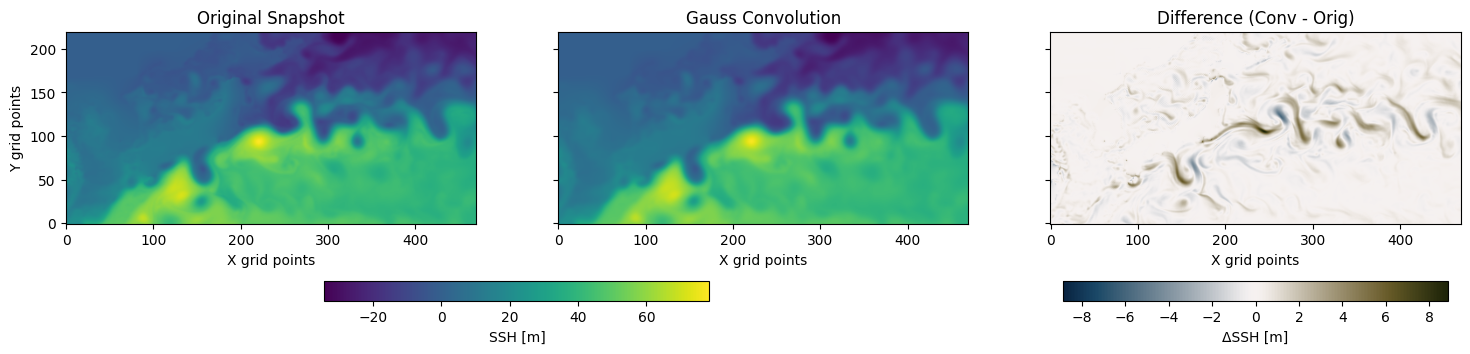

In [92]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
conv = conv_gauss[ymin:ymax, xmin:xmax]
diff = conv - orig

# Common vmin/vmax for orig and conv
vmin = min(orig.min(), conv.min())
vmax = max(orig.max(), conv.max())

# Symmetric range for difference
diff_absmax = np.abs(diff).max()

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot original
im0 = axs[0].imshow(orig, origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")  # Only y-label here

# Plot convolved
im1 = axs[1].imshow(conv, origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_title("Gauss Convolution")
axs[1].set_xlabel("X grid points")

# Plot difference with symmetric color limits
im2 = axs[2].imshow(diff, origin='lower', cmap=cmocean.cm.diff, vmin=-diff_absmax, vmax=diff_absmax)
axs[2].set_title("Difference (Conv - Orig)")
axs[2].set_xlabel("X grid points")

# Shared colorbar for original and convolved
cbar = fig.colorbar(im1, ax=axs[:2], orientation='horizontal', fraction=0.05, pad=0.15)
cbar.set_label("SSH [m]")

# Symmetric colorbar for difference
cbar_diff = fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.05, pad=0.15)
cbar_diff.set_label('ΔSSH [m]')

# plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


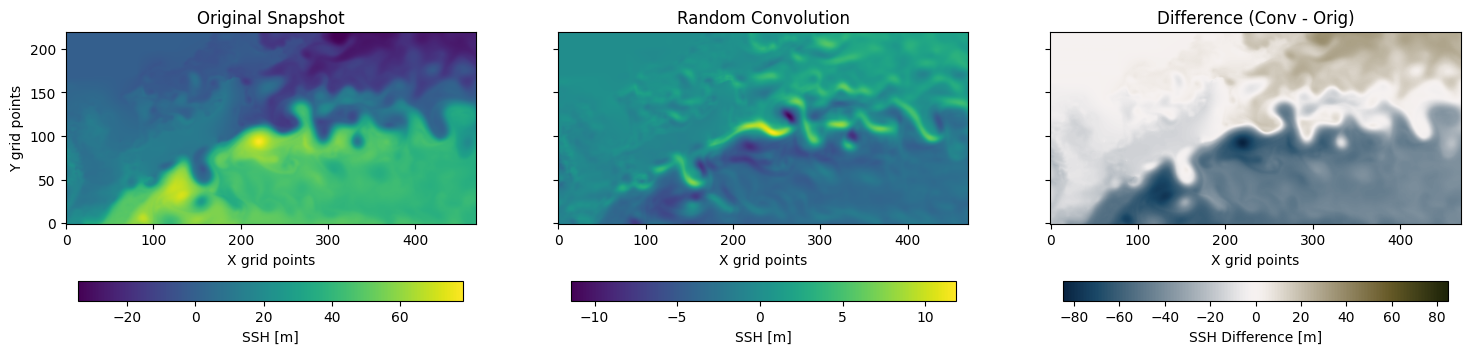

In [96]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
conv = conv_random[ymin:ymax, xmin:xmax]
diff = conv - orig

# Symmetric range for difference
diff_absmax = np.abs(diff).max()

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot convolved with its own color scale
im1 = axs[1].imshow(conv, origin='lower')
axs[1].set_title("Random Convolution")
axs[1].set_xlabel("X grid points")

# Plot difference with symmetric color scale
im2 = axs[2].imshow(diff, origin='lower', cmap=cmocean.cm.diff,
                    vmin=-diff_absmax, vmax=diff_absmax)
axs[2].set_title("Difference (Conv - Orig)")
axs[2].set_xlabel("X grid points")

# Independent colorbars for all plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH Difference [m]")

# plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


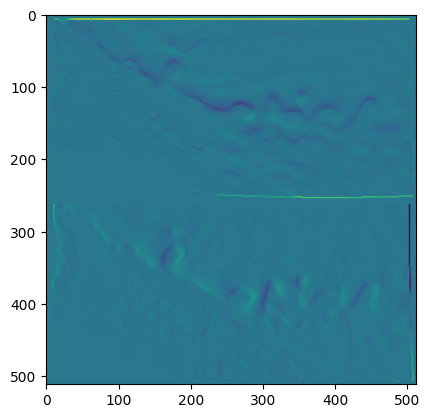

In [100]:
plt.imshow(gradient)

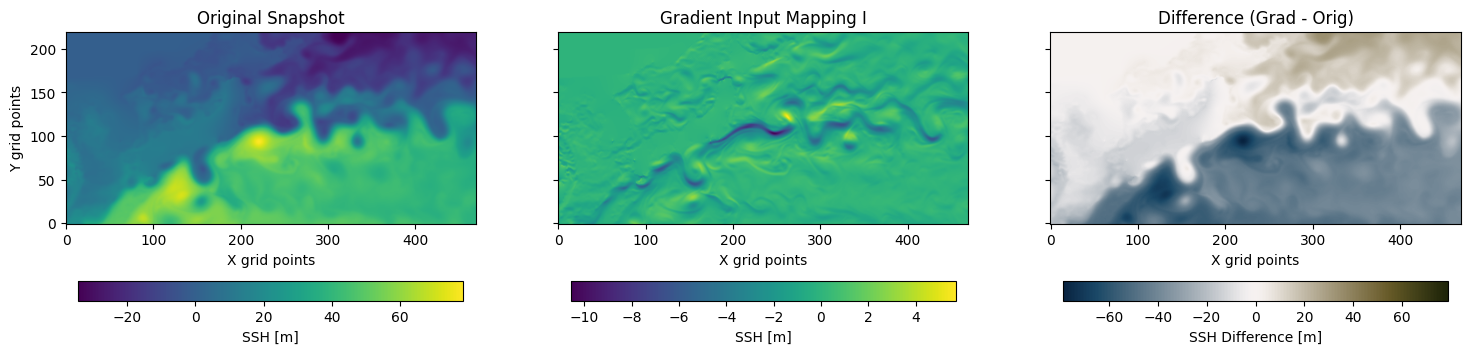

In [ ]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
grad = gradient[ymin:ymax, xmin:xmax]
diff = grad - orig

# Symmetric range for difference
diff_absmax = np.abs(diff).max()

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot convolved with its own color scale
im1 = axs[1].imshow(grad, origin='lower')
axs[1].set_title("Gradient Input Map I")
axs[1].set_xlabel("X grid points")

# Plot difference with symmetric color scale
im2 = axs[2].imshow(diff, origin='lower', cmap=cmocean.cm.diff,
                    vmin=-diff_absmax, vmax=diff_absmax)
axs[2].set_title("Difference (Grad - Orig)")
axs[2].set_xlabel("X grid points")

# Independent colorbars for all plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH Difference [m]")

# plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


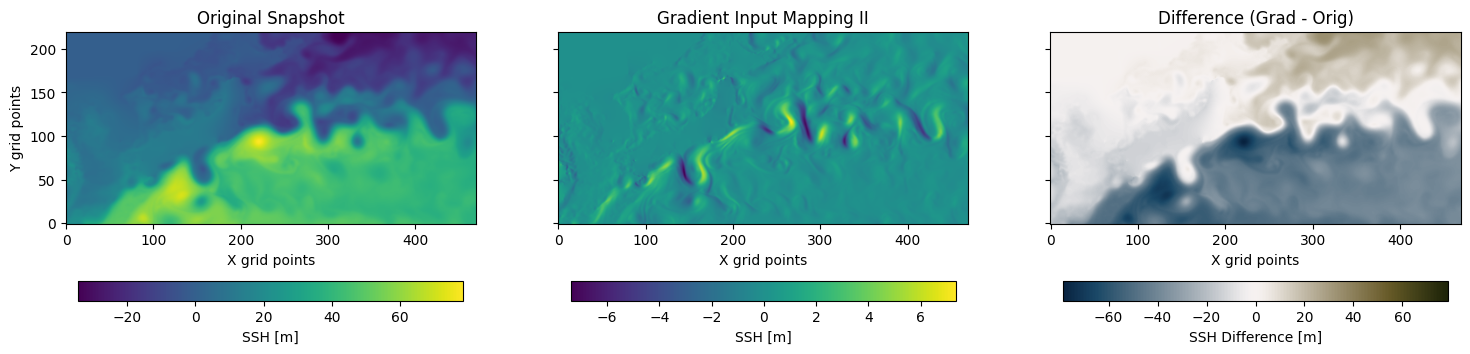

In [ ]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
grad = gradient[276:496, xmin:xmax]
diff = grad - orig

# Symmetric range for difference
diff_absmax = np.abs(diff).max()

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot convolved with its own color scale
im1 = axs[1].imshow(grad, origin='lower')
axs[1].set_title("Gradient Input Map II")
axs[1].set_xlabel("X grid points")

# Plot difference with symmetric color scale
im2 = axs[2].imshow(diff, origin='lower', cmap=cmocean.cm.diff,
                    vmin=-diff_absmax, vmax=diff_absmax)
axs[2].set_title("Difference (Grad - Orig)")
axs[2].set_xlabel("X grid points")

# Independent colorbars for all plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH Difference [m]")

# plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


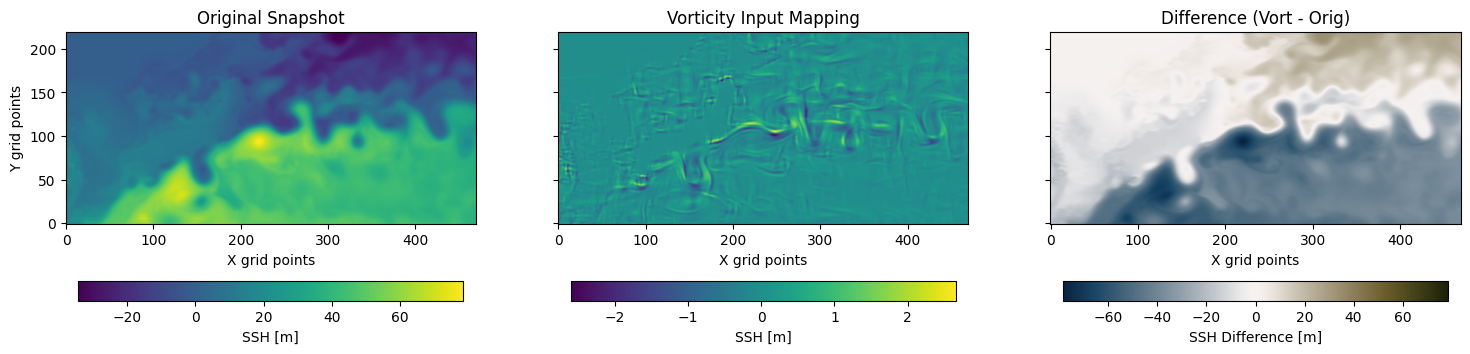

In [ ]:
# Define region
ymin, ymax = 20, 240
xmin, xmax = 20, 490

# Extract slices
orig = data_snapshot[ymin:ymax, xmin:xmax]
vort = vorticity[ymin:ymax, xmin:xmax]
diff = vort - orig

# Symmetric range for difference
diff_absmax = np.abs(diff).max()

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# Plot original with its own color scale
im0 = axs[0].imshow(orig, origin='lower')
axs[0].set_title("Original Snapshot")
axs[0].set_xlabel("X grid points")
axs[0].set_ylabel("Y grid points")

# Plot convolved with its own color scale
im1 = axs[1].imshow(vort, origin='lower')
axs[1].set_title("Vorticity Input Map")
axs[1].set_xlabel("X grid points")

# Plot difference with symmetric color scale
im2 = axs[2].imshow(diff, origin='lower', cmap=cmocean.cm.diff,
                    vmin=-diff_absmax, vmax=diff_absmax)
axs[2].set_title("Difference (Vort - Orig)")
axs[2].set_xlabel("X grid points")

# Independent colorbars for all plots
fig.colorbar(im0, ax=axs[0], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im1, ax=axs[1], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH [m]")
fig.colorbar(im2, ax=axs[2], orientation='horizontal', fraction=0.05, pad=0.15).set_label("SSH Difference [m]")

# plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


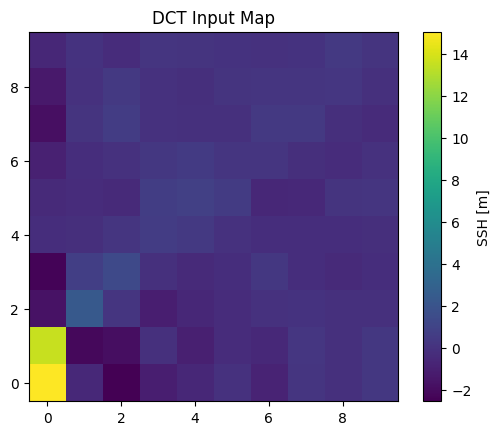

In [120]:
plt.Figure
plt.imshow(dct, origin='lower')
plt.colorbar(label = "SSH [m]")
plt.title("DCT Input Map")
plt.show()

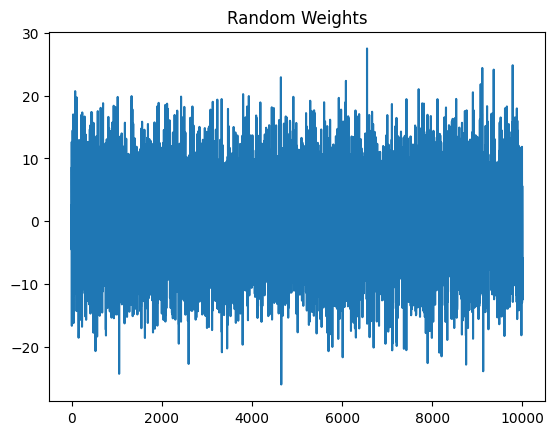

In [123]:
plt.Figure
plt.plot(rand_weights)
plt.title("Random Weights")
plt.show()
